# _Python for Scientific Data Analysis_


#  AstroPy and AstroQuery

## Section 4: Centroiding and Photometry

In AstroPy sections 1--3 we discussed reading in and writing FITS files, reading and writing tables, using units and coordinates, and querying astronomical object properties from databases.   

In section 4 we will discuss the basics of fundamental astronomical measurements using Python: photometry.  

For most of this section, we will be using the package called ``photutils``.  

Photutils can be used for ...

- Background and background noise estimation
- Source Detection and Extraction
  - DAOFIND and IRAF's starfind
  - Image segmentation
  - local peak finder
- Aperture photometry
- PSF photometry
- empirical PSF building
- PSF matching
- Centroids
- Morphological properties
- Elliptical isophote analysis

Now, the core AstroPy package itself does not have a subpackage for photometry.  However, like apparently many other pieces of code ``photutils`` is an _affiliated package_ , meaning that it is "_not managed by the project but is a part of the Astropy Project community_".   

In this way it is similar to _astroquery_ , which is another affiliated package.

We will also be using a separate lineage of code for photometry/centroiding etc that is a direct translation of the very robust IDL photometry package of routines.   Primary credit to these packages goes to David Jones (at Johns Hopkins at the time; now at University of Hawaii): https://github.com/djones1040  .  

He calls this package **PythonPhot**.  I will also be adding one more piece of code that a former student of mine wrote a few summers ago.

### Installation: Photutils

You can install photutils separately using either pip or conda 

#pip

``pip install photutils``

#conda 

``conda install -c conda-forge photutils ``


Note that photutils recently underwent a bunch of upgrades.  If -- like me -- you had an older version of photutils, you can install the upgraded version using pip

``pip install --upgrade photutils``

### Installation: PythonPhot

You can find PythonPhot here: 

https://github.com/djones1040/PythonPhot

For installation, "git clone" the repository and then running the setup.py program should work 

On the other hand, if you want a total "manual" installation you can make it work by manually adding the package to my PYTHONPATH variable.  See notes in class for how to do this.


### Preliminaries

As before, we start with the standard import calls for NumPy and Matplotlib.   Additionally, since we will be displaying a lot of images, we define the origin ahead of time to be 'lower' (so the images do not display upside-down).

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
import matplotlib as mpl
mpl.rcParams['image.origin'] = 'lower'

First, we will discuss centroiding within Photutils and Pythonphot.  When using the same algorithms, they basically give the same answers, but it is important to understand how they calculate the centroid positions in each case.

### Centroiding

###  _Centroiding with Photutils_

The ``centroids`` subpackage performs centroiding with photutils, which is imported as follows

In [6]:
from photutils import centroids
from photutils.centroids import *
import photutils
photutils.__version__

'1.9.0'

The main function used for centroiding with Photutils is ``centroid_sources``.  The full API is found here: https://photutils.readthedocs.io/en/stable/api/photutils.centroids.centroid_sources.html

The basic call for this function is ``result=centroid_sources(image_array,xpos,ypos,boxsize=boxsize,footprint=footprint,centroid_func=centroid_func)``.

Here, "result" is a tuple with values of the xcentroid and ycentroid: e.g. "xcen,ycen = centroid_sources(stuff)".

``image`` is the 2D image array; ``xpos`` and ``ypos`` are the starting guess positions for sources on the array.  

In order to centroid a source, you need to tell Python the "region of interest" (ROI) to consider.  The ``boxsize`` and ``footprint`` keywords take care of that.  By default (i.e. if you do not give it any commands), the function assumes a boxsize of 11 pixels.   You can set ``footprint`` to some non-square region defining your ROI.   

So ... which algorithm do you use for centroiding sources? There are a couple of options:

* ``centroid_com`` - this is basically a simple "center of light" calculation roughly equivalent to the "center of mass" calculation you learned in freshman physics: i.e. 
$\textbf{R}$ = $\sum_{i=1}^{N}({m_{i}*r_{i}})/\sum_{i=1}^{N} {r_{i}}$.   This is usually a decent approach if your source is extended.  But there are better approaches otherwise.

* ``centroid_1dg`` - Calculates the centroid by fitting 1D Gaussians to the marginal x and y distributions of the data. (better)

* ``centroid_2dg`` - Calculate the centroid of a 2D array by fitting a 2D Gaussian (plus a constant) to the array. (also better)

Let's start with a simple example: these files are sections of the HST Extreme-Deep Field (XDF) taken with WFC3/IR in the F160W filter.  The data are already background subtracted and ready for centroiding.

In [7]:
sci_fn = 'data/xdf_hst_wfc3ir_60mas_f160w_sci.fits'
#rms_fn = 'data/xdf_hst_wfc3ir_60mas_f160w_rms.fits'
sci_hdulist = fits.open(sci_fn)
#rms_hdulist = fits.open(rms_fn)


In [8]:
#print out the fits header information to get information about the file
sci_hdulist.info()

Filename: data/xdf_hst_wfc3ir_60mas_f160w_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (200, 200)   float32   


In [9]:
data=sci_hdulist[0].data
data.shape

(200, 200)

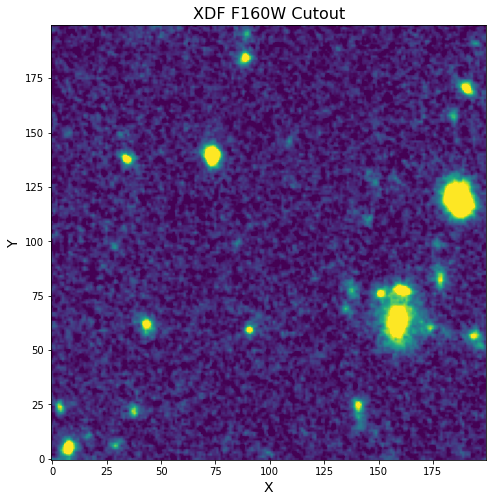

In [10]:
#display the data
from astropy.visualization import simple_norm
norm = simple_norm(data, 'linear')
#square-root display

plt.figure(figsize=(8, 8))
clims=np.nanpercentile(data,[10,99])

plt.imshow(data, clim=clims,norm=norm)
plt.xlabel('X',fontsize=14)
plt.ylabel('Y',fontsize=14)
plt.title('XDF F160W Cutout',fontsize=16);

If we examine the image, we see a bunch of obvious astrophysical sources.  Let's take the one in the bottom-center.  It looks like it has a position of about x=90 and y=60 or so.   So let's use this as our starting position for centroiding and see what results we get.

In [11]:
xo=90
yo=60

#simple center of mass
#result=centroid_sources(data,xo,yo,box_size=11,centroid_func=centroid_com)
xcom,ycom = centroid_sources(data,xo,yo,box_size=11,centroid_func=centroid_com)

#1d gaussian fit to marginal x & y distributions
x1d,y1d = centroid_sources(data,xo,yo,box_size=11,centroid_func=centroid_1dg)


#2d gaussian fit to entire array
x2d,y2d = centroid_sources(data,xo,yo,box_size=11,centroid_func=centroid_2dg)

print(xcom,ycom)
print(x1d,y1d)
print(x2d,y2d)

[91.10524966] [59.54450888]
[91.00376841] [59.33856324]
[90.8274169] [59.39047396]


Now, as you can see we get a warning with the 2d gaussian fit that it "may be unsuccessful".  The "centroid_2dg" function is calling an LM least-squares fit to find the local maximum.  So this warning error suggest that the fit may not have converged, even though the answer is comparable to those we found with the other methods.

Let's do some examining first of the estimated centroids and then of the intrinsic source intensity distribution.

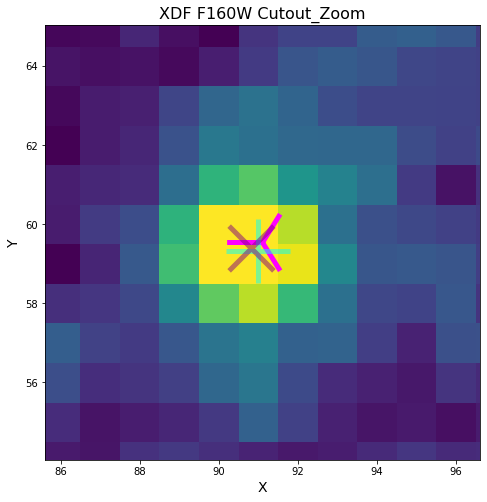

In [12]:
#plotting the centroid positions

plt.figure(figsize=(8, 8))
clims=np.nanpercentile(data,[10,99])

window=11/2.  #equal to the box size we are using for centroiding

plt.imshow(data, clim=clims,norm=norm)
plt.xlabel('X',fontsize=14)
plt.ylabel('Y',fontsize=14)
plt.xlim(xcom-window,xcom+window)
plt.ylim(ycom-window,ycom+window)
#overplot the centroids




marker=['3','+','x']
mcolor=['magenta','cyan','purple']
linewidths=[5,5,5]
msize=[5000,4000,2000]
#msize=[100,100,100]
alphaval=[1,0.5,0.5]
xval=[xcom,x1d,x2d]
yval=[ycom,y1d,y2d]

for i in range(0,3):
# print(i)
 plt.scatter(xval[i],yval[i],marker=marker[i],color=mcolor[i],s=msize[i],linewidths=linewidths[i],alpha=alphaval[i])
    
#plt.scatter(xcom,ycom,marker=marker[1],color='tab:orange',s=msize[1],alpha=0.5)    
#plt.scatter(x1d,y1d,marker=marker[1],color='red',s=msize[1],alpha=0.5)
#plt.scatter(x2d,y2d,marker=marker[2],color='magenta',s=msize[2],alpha=0.5)



plt.title('XDF F160W Cutout_Zoom',fontsize=16);

As you can see, there is very little signal beyond about 3 pixels from the center of this source: our box size is likely a bit too large and could be throwing off the centroid estimates.

We can verify this better by calculating the "Radial-Profile" for this source centered on the center-of-mass centroid position (this will be good enough for our purposes).  See below ...

Text(0.5, 0, 'Pixels')

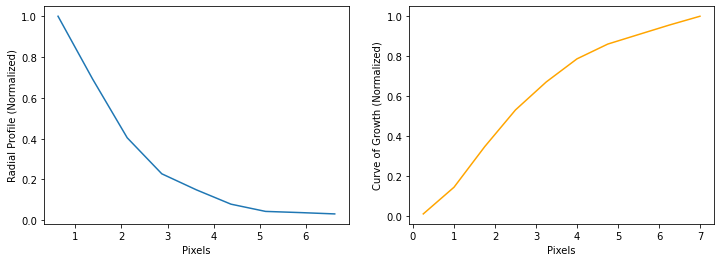

In [13]:
#import additional stuff

from photutils.profiles import RadialProfile,CurveOfGrowth

radii=np.linspace(0.25,7,10)
#radii=np.arange(1,5)


rp=RadialProfile(data,(xcom[0],ycom[0]),radii,error=None,mask=None)
cog=CurveOfGrowth(data,[xcom[0],ycom[0]],radii,error=None,mask=None)
#print(radii)

fig,axes=plt.subplots(1,2,figsize=(12,4))
axes[0].plot(rp.radius,rp.profile/np.max(rp.profile))
axes[0].set_ylabel('Radial Profile (Normalized)')
axes[0].set_xlabel('Pixels')
axes[1].plot(cog.radius,cog.profile/np.max(cog.profile),color='orange')
axes[1].set_ylabel('Curve of Growth (Normalized)')
axes[1].set_xlabel('Pixels')


You can fairly easily see that the source falls to half of its peak intensity about 2 pixels away from the (rough) center; this radius contains about half of the total signal of the source.  At 5.5 pixels away from the center (i.e. a boxsize=11) the source signal is only about 1/10th the peak value: i.e. it is a noisy estimate.  That could be throwing off our centroiding algorithms a bit.  So let's redo the calculation with a smaller box size (say, half the original value = 5.5).

In [14]:
xo=90
yo=60

boxsizev2=5
#simple center of mass
xcomv2,ycomv2 = centroid_sources(data,xo,yo,box_size=boxsizev2,centroid_func=centroid_com)

#1d gaussian fit to marginal x & y distributions
x1dv2,y1dv2 = centroid_sources(data,xo,yo,box_size=boxsizev2,centroid_func=centroid_1dg)


#2d gaussian fit to entire array
x2dv2,y2dv2 = centroid_sources(data,xo,yo,box_size=boxsizev2,centroid_func=centroid_2dg)

print(xcomv2,ycomv2)
print(x1dv2,y1dv2)
print(x2dv2,y2dv2)

[90.53269255] [59.61346858]
[90.77697068] [59.33733411]
[90.78330852] [59.37879252]


###  _Centroiding with PythonPhot (and associated code)_ 

Now we will do the same thing with code from PythonPhot and a direct IDL-to-Python translation of the gaussian centroiding fit which is extremely similar to the ``centroid_1dg`` function with photutils, though there are some slight differences under-the-hood.

(the PythonPhot version follows the IDL source code and does a Gaussian convolution kernel ... it looks like the approach is slightly different with photutils).  

if you add some directory to your PYTHONPATH variable and then create another directory under it called, say, "pythonphot" you then do the following command to import the source cod

In [15]:
from pythonphot import cntrd

#note you can also do from pythonphot.cntrd import cntrd to just access the function within cntrd.py

This algorithm is fairly fast and straightforward.  Centroids by locating the position where the X and Y derivatives go to zero.   This is usually a more "robust"  determination than a "center of mass".  It "can" be better than fitting a 2d Gaussian if the wings in one direction are affected by the presence of a neighboring star.

Here, the syntax is ``cntrd(image,xguess,yguess,fwhm,[other keywords]``.   The "FWHM" is not a circular full-width at half maximum, strictly speaking.  It is a floating scalar; the centroid is computed using a box of half width equal to 1.5 sigma = 0.637* fwhm.  So to make the most "apples to apples" comparison with photutils, you want 2x0.637xfwhm to equal boxsizev2, or about 3.92 in this particular case

In [16]:
#cntrd.cntrd(data,xo,yo,boxsizev2/2)
cntrd.cntrd(data,xo,yo,3.92)

(90.8196577795512, 59.272680633738545)

The answer we get is very similar to the photutils value

Now we will do the same thing with code from PythonPhot and a direct IDL-to-Python translation of the gaussian centroiding fit -- ``gcntrd.py`` -- which is extremely similar to the ``centroid_1dg`` function with photutils, though there are some slight differences under-the-hood.

(the PythonPhot version follows the IDL source code and does a Gaussian convolution kernel ... it looks like the approach is slightly different with photutils).  

First we import this function...

In [17]:
#from pythonphot import gcntrd
from pythonphot.gcntrd import gcntrd

Running it is very similar to cntrd.py ....
``gcntrd(image,xguess,yguess,fwhm,[other keywords]``

In [18]:
gcntrd(data,xo,yo,3.92)

(90.78903726829014, 59.365044657545674)

Here, the answer is within about 0.02 pixels of the photutils value: the differences mainly due to the Gaussian convolution approach (which obviously doesn't matter much here)

### Photometry with Photutils
(**credit**: much of this section is borrowed from an Astropy workshop held a few years ago)

Below are steps to perform simple aperture photometry with Photutils

#### Load the data

We'll start by reading data and error arrays from FITS files.  These are cutouts from the HST Extreme-Deep Field (XDF) taken with WFC3/IR in the F160W filter.

In [19]:
#sci_fn = 'data/xdf_hst_wfc3ir_60mas_f160w_sci.fits' #already read in
rms_fn = 'data/xdf_hst_wfc3ir_60mas_f160w_rms.fits'
#sci_hdulist = fits.open(sci_fn) #already read in
rms_hdulist = fits.open(rms_fn)

sci_hdulist[0].header
sci_hdulist[0].header['BUNIT'] = 'electron/s'

In [20]:
#print out the fits header information to get information about the file
sci_hdulist.info()

Filename: data/xdf_hst_wfc3ir_60mas_f160w_sci.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (200, 200)   float32   


In [21]:
#define the data and error arrays
data=sci_hdulist[0].data #already done
error=rms_hdulist[0].data

In [22]:
#extract the data header and create a WCS object
from astropy.wcs import WCS
hdr = sci_hdulist[0].header
wcs = WCS(hdr)

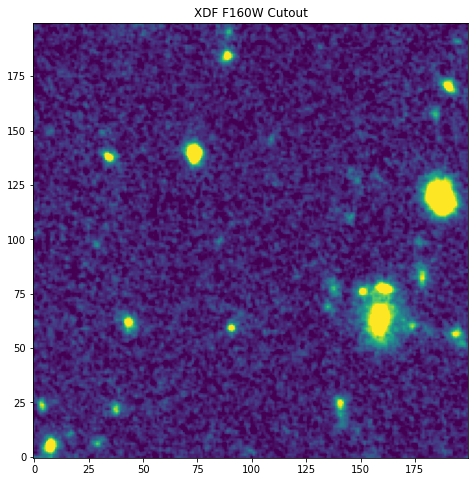

In [23]:
#display the data
from astropy.visualization import simple_norm
norm = simple_norm(data, 'linear')
#square-root display

plt.figure(figsize=(8, 8))
clims=np.nanpercentile(data,[10,99])

plt.imshow(data, clim=clims,norm=norm)
plt.title('XDF F160W Cutout');

Photutils provides circular, elliptical, and rectangular aperture shapes (plus annulus versions of each).  These are names of the aperture classes, defined in pixel coordinates:

* `CircularAperture`
* `CircularAnnulus`

* `EllipticalAperture`
* `EllipticalAnnulus`

* `RectangularAperture`
* `RectangularAnnulus`

Along with variants of each, defined in celestial coordinates:

* `SkyCircularAperture`
* `SkyCircularAnnulus`

* `SkyEllipticalAperture`
* `SkyEllipticalAnnulus`

* `SkyRectangularAperture`
* `SkyRectangularAnnulus`

Here's a graphical depiction of how these work:
<img src='data/apertures.png' alt='Figure of aperture shapes' width=700px>

#### Methods for handling aperture/pixel intersection

In general, the apertures will only partially overlap some of the pixels in the data.

There are three methods for handling the aperture overlap with the pixel grid of the data array.

<img src="data/photutils_aperture_methods.svg">

NOTE:  the `subpixels` keyword is ignored for the **'exact'** and **'center'** methods.

#### Perform circular-aperture photometry on some sources in the XDF

First, we define a circular aperture at a given position and radius (in pixels).

In [24]:
from photutils import CircularAperture

#position = (90.73, 59.43)  # (x, y) pixel position

position = (x1dv2[0],y1dv2[0])  # (x, y) pixel position
radius = 5  # pixels
aperture = CircularAperture(position, r=radius)

print(aperture)

Aperture: CircularAperture
positions: [90.77697068, 59.33733411]
r: 5.0


/var/folders/jd/2nq0dfy94lsddczv0kg2y33h0000gn/T/ipykernel_35810/2156140545.py:1: DeprecationWarning: `photutils.CircularAperture` is a deprecated alias for `photutils.aperture.CircularAperture` and will be removed in the future. Instead, please use `from photutils.aperture import CircularAperture` to silence this warning.
  from photutils import CircularAperture


(<matplotlib.patches.Circle at 0x14c5034c0>,)

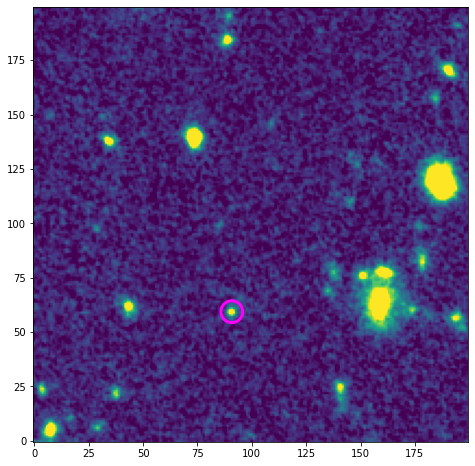

In [25]:
plt.figure(figsize=(8, 8))
plt.imshow(data, clim=clims)
aperture.plot(color='magenta', lw=3)

Now let's perform photometry on the data using the `aperture_photometry()` function.  **The default aperture method is 'exact'.**

Also note that the input data is assumed to have zero background.  If that is not the case, please see the documentation for the `photutils.background` subpackage for tools to help subtract the background.



The background was already subtracted for our XDF example data.

Now, we actually do aperture photometry

In [26]:
#from photutils import aperture_photometry
from photutils.aperture import aperture_photometry

#accurate
phot = aperture_photometry(data, aperture)
#phot

#slightly less accurate
phot2 = aperture_photometry(data, aperture, method='center')
#phot2

#accurate
phot3 = aperture_photometry(data, aperture, method='subpixel', subpixels=5)
#phot3


phot3

print(phot)
print("")
print(phot2)
print("")
print(phot3)

 id      xcenter           ycenter          aperture_sum   
           pix               pix                           
--- ----------------- ----------------- -------------------
  1 90.77697067641347 59.33733411380751 0.12048293440718412

 id      xcenter           ycenter          aperture_sum   
           pix               pix                           
--- ----------------- ----------------- -------------------
  1 90.77697067641347 59.33733411380751 0.12032535461730731

 id      xcenter           ycenter          aperture_sum   
           pix               pix                           
--- ----------------- ----------------- -------------------
  1 90.77697067641347 59.33733411380751 0.12036081178215682


The output is an Astropy QTable (Quantity Table) with sum of data values within the aperture (using the defined pixel overlap method).

The table also contains metadata, which is accessed by the meta attribute of the table. The metadata is stored as a python (ordered) dictionary:

In [27]:
phot.meta

{'name': 'Aperture photometry results',
 'version': {'Python': '3.10.4',
  'photutils': '1.9.0',
  'astropy': '5.1',
  'numpy': '1.21.6',
  'scipy': '1.8.0',
  'skimage': '0.19.3',
  'sklearn': '1.3.0',
  'matplotlib': '3.5.1',
  'gwcs': '0.18.1',
  'bottleneck': '1.3.5'},
 'aperture_photometry_args': "method='exact', subpixels=5"}

### Photometric Errors

We can also input an error array to get the photometric errors.

The error array in our XDF FITS file represents only the background error.  If we want to include the Poisson error of the source we need to calculate the **total** error (in the same units as the data):

$\sigma_{\mathrm{tot}} = \sqrt{\sigma_{\mathrm{b}}^2 +
                  \frac{I}{g}}$
                  
where $\sigma_{\mathrm{b}}$ is the background-only error,
$I$ are the data values, and $g$ is the "effective gain".

The "effective gain" is the value (or an array if it's variable across an image) needed to convert the data image to count units (e.g. electrons or photons), where Poisson statistics apply.

Photutils provides a `calc_total_error()` function to perform this calculation.

In [29]:
from photutils.utils import calc_total_error

#phot = aperture_photometry(data, aperture, error=error)
#print(phot)

# this time include the Poisson error of the source

# our data array is in units of e-/s
# so the "effective gain" should be the exposure time
eff_gain = hdr['TEXPTIME']
tot_error = calc_total_error(data, error, eff_gain)

phot = aperture_photometry(data, aperture, error=tot_error)
print(phot)
#tot_error

 id      xcenter           ycenter          aperture_sum      aperture_sum_err  
           pix               pix                                                
--- ----------------- ----------------- ------------------- --------------------
  1 90.77697067641347 59.33733411380751 0.12048293440718412 0.008044029550734673


### Units

We can also consider units for our photometry

In [30]:
from astropy import units as u
unit = u.electron / u.s  # unit for the data and error arrays
phot = aperture_photometry(data * unit, aperture, error=tot_error * unit)
print(phot)

 id      xcenter           ycenter          aperture_sum      aperture_sum_err  
           pix               pix            electron / s        electron / s    
--- ----------------- ----------------- ------------------- --------------------
  1 90.77697067641347 59.33733411380751 0.12048293440718412 0.008044029550734673


### Performing aperture photometry at multiple positions

Now let's perform aperture photometry for three sources (all with the same aperture size). We simply define three (x, y) positions.  Note here for simplicity we just enter positions roughly equal to (within 0.2 pixels) the actual centroid positions.

In [31]:
positions = [(90.73, 59.43), (73.63, 139.41), (43.62, 61.63)]
radius = 5.
apertures = CircularAperture(positions, r=radius)

#An aperture object with multiple positions can be indexed or sliced to get a subset of apertures:
#apertures[1]  # aperture for the second position
#apertures[0:2]  # apertures for the first two positions
#apertures

id,xcenter,ycenter,aperture_sum,aperture_sum_err
,pix,pix,electron / s,electron / s
int64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023138750599
2,73.63,139.41,0.6150243632978062,0.008166280776044187
3,43.62,61.63,0.213526159948924,0.008069761400151903


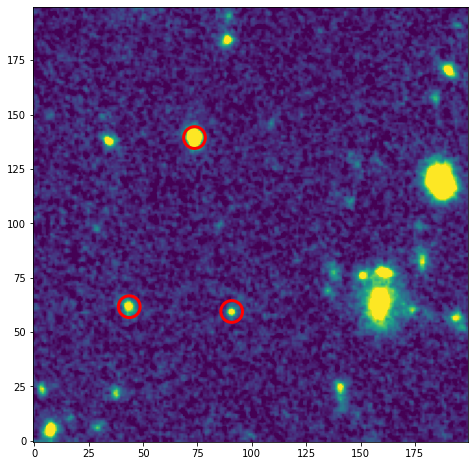

In [32]:
#Let's plot all three apertures
plt.figure(figsize=(8, 8))
plt.imshow(data, norm=norm)
apertures.plot(color='red', lw=3)

#and perform aperture photometry
phot = aperture_photometry(data * unit, apertures, error=tot_error * unit)
phot

#Each source is a row in the table and is given a unique **id** (the first column).

### Adding columns to the photometry table

We can add columns to the photometry table. Let's calculate the signal-to-noise (SNR) ratio of our sources and add it as a new column to the table.

**Caution** - here "SNR" is really the photometric uncertainty and assumes that we are photon noise/background limited.  This is not generally true in the case of high-contrast imaging where the noise is spatially correlated ... 

In [33]:
snr = phot['aperture_sum'] / phot['aperture_sum_err']  # units will cancel

phot['snr'] = snr
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err,snr
,pix,pix,electron / s,electron / s,
int64,float64,float64,float64,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023138750599,14.966583729142496
2,73.63,139.41,0.6150243632978062,0.008166280776044187,75.31266437739716
3,43.62,61.63,0.213526159948924,0.008069761400151903,26.460033867284434


Now calculate the F160W AB magnitude and add it to the table.

In [94]:
f160w_zpt = 25.9463  # HST/WFC3 F160W zero point

# NOTE that the log10() function can be applied only to dimensionless quantities
# so we use the value() method to get the number value of the aperture sum
abmag = -2.5 * np.log10(phot['aperture_sum'].value) + f160w_zpt

phot['abmag'] = abmag
phot
phot['aperture_sum'].value #if you just want to return the value as an array

array([0.12039155, 0.61502436, 0.21352616])

Now, using the WCS defined above, calculate the sky coordinates for these objects and add it to the table.

In [40]:
# convert pixel positions to sky coordinates
x, y = np.transpose(positions)
coord = wcs.pixel_to_world(x, y)

# we can add the astropy SkyCoord object directly to the table
phot['sky_coord'] = coord
phot

#or separate RA & DEC columns
phot['ra_icrs'] = coord.icrs.ra
phot['dec_icrs'] = coord.icrs.dec
phot

id,xcenter,ycenter,aperture_sum,aperture_sum_err,snr,abmag,sky_coord,ra_icrs,dec_icrs
,pix,pix,electron / s,electron / s,,,"deg,deg",deg,deg
int64,float64,float64,float64,float64,float64,float64,SkyCoord,float64,float64
1,90.73,59.43,0.12039154582527045,0.008044023138750599,14.966583729142496,28.24481002294352,"53.158891500867604,-27.765002141410175",53.15888794969764,-27.76499923317225
2,73.63,139.41,0.6150243632978062,0.008166280776044187,75.31266437739716,26.474069199845104,"53.15921313626186,-27.763669058236427",53.15920958492472,-27.76366614996854
3,43.62,61.63,0.213526159948924,0.008069761400151903,26.460033867284434,27.62267227553782,"53.159778816470286,-27.764965241221894",53.15977526527222,-27.76496233290131


If we write the table to an ASCII file using the ECSV format, we can read it back in preserving all of the units, metadata, and SkyCoord objects.

In [41]:
phot.write('my_photometry.txt', format='ascii.ecsv',overwrite=True)

In [263]:
from astropy.table import QTable
tbl = QTable.read('my_photometry.txt', format='ascii.ecsv')
tbl


tbl.meta

tbl['aperture_sum']  # Quantity array
tbl['sky_coord']  # SkyCoord array

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(53.1588915 , -27.76500214), (53.15921314, -27.76366906),
     (53.15977882, -27.76496524)]>

### Aperture Photometry with Multiple Apertures at Each Position

To perform photometry in multiple apertures at each position, input a list of aperture objects to the ``aperture_photometry()`` function. In this case, the apertures must all have identical position(s).

E.g. To use three circular apertures, with radii of 5, 6, and 7 pixels, on each source:

In [272]:
radii = [5.0,6.0,7.0]

apertures = [CircularAperture(positions, r=r) for r in radii]

phot_table2=aperture_photometry(data * unit, apertures, error=tot_error * unit)

phot_table2['snr0'] = phot_table2['aperture_sum_0'] / phot_table2['aperture_sum_err_0']
phot_table2['snr1'] = phot_table2['aperture_sum_1'] / phot_table2['aperture_sum_err_1']
phot_table2['snr2'] = phot_table2['aperture_sum_2'] / phot_table2['aperture_sum_err_2']

for col in phot_table2.colnames:
        phot_table2[col].info.format = '%.5g'

#phot_table = aperture_photometry(data, apertures)

phot_table2

id,xcenter,ycenter,aperture_sum_0,aperture_sum_err_0,aperture_sum_1,aperture_sum_err_1,aperture_sum_2,aperture_sum_err_2,snr0,snr1,snr2
,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,90.73,59.43,0.12039,0.008044,0.12903,0.0096455,0.13607,0.011248,14.967,13.378,12.097
2,73.63,139.41,0.61502,0.0081663,0.67791,0.0097699,0.71993,0.011372,75.313,69.388,63.31
3,43.62,61.63,0.21353,0.0080698,0.2421,0.0096819,0.25918,0.011291,26.46,25.006,22.955


We can see here from a signal-to-noise ratio standpoint that the smallest aperture radius appears best even though it encloses the least amount of signal

### Photometry (PythonPhot)

In my personal opinion, AstroPy and associated packages are great but can be a bit of a black box for those who aren't ultra-familiar with all the fine Class/Object, etc idiosyncracies of Python.   Photutils is a particularly unwieldy example for reasons that you will see below, that highlights the importance of clearly understanding your input.

To compare our results with the prior industry standard (the IDL astronomer's library version of DAOPHOT + improvements), we also perform photometry with PythonPhot.

For PythonPhot (which follows the original IDL code almost line-by-line), the function you need to use is ``aper``, which is imported as ....




In [43]:
from pythonphot import aper

The calling sequence looks like ...

``aper.aper(image,xc,yc, phpadu=1, apr=5, zeropoint=25,skyrad=[40,50], badpix=[0,0], 
         setskyval = None, minsky=[],skyalgorithm='mmm', exact = False, readnoise = 0,
            verbose=True,debug=False)``

The key parameters are:

* apr - the aperture radius (in pixels)
* xc,yc - the source position
* phpadu - photons per analog digital units: the effective gain. 


* setskyval - Manually set the sky background.  You can also set to some value (in which case the sky error will be zero since the sky value is perfectly known) ... OR you can set an array equal to [sky value, sigma of the sky value, and number of elements used to compute the sky value].  E.g. ``setskyval=[0.1,0.005,10]`` if the sky background is set to a constant value of 0.1, has an uncertainty of 0.005 and was computed over 10 pixels.
* skyalgorithm - the venerable 'mmm' subroutine or a sigma-clipped background determination
* skyrad - a two-element array defining the inner and outer annulus for determining the sky background [if applicable]

* exact = [True/False] -- By default, ``aper`` counts subpixels (just like photutils), but uses a polygon approximation for the intersection of a circular aperture with a square pixel (and normalize the total area of the sum of the pixels to exactly match the circular area).   If the /exact keyword, then the intersection of the circular aperture with a square pixel is computed exactly.   /exact is slower but ostensibly more accurate.

This call then returns a tuple of ``mag,emag,flux,eflux,sky,skyerr,[other stuff]``.  I.e. to access the flux measurement and its uncertainty, you can also do ``result=aper.aper([keywords])`` and then ``flux=result[2]; eflux[3]``.

So, what should go into these values?   First, following our photutils example, let's work through them.   First, the aperture we used was 5 pixels, so let's set ``apr`` equal to that.  ``phpadu`` controls the effective gain (To get us into photon units) and that was calculated before as ``eff_gain``.   Our data are already background subtracted, so ostensibly the sky background value is 0.    

Now we proceed to calculate photometry at the three positions specified before...

In [97]:
#aperture, determined above
apradius=5
#determined above
gain=eff_gain 

#the input positions used for photutils
positions = [(90.73, 59.43), (73.63, 139.41), (43.62, 61.63)]
#list comprehensions to read all this stuff in
xpos = [positions[xn][0] for xn in range(0,3)]
ypos = [positions[xn][1] for xn in range(0,3)]

result=aper.aper(data,xpos,ypos,apr=5,setskyval=0,phpadu=eff_gain)

flux,eflux=result[2],result[3]
flux.flatten(),eflux.flatten() #just to make the output display in a cleaner way

(array([0.12041161, 0.61499865, 0.21353256]),
 array([0.00060349, 0.00136386, 0.00080365]))

Now, the aperture-sum basically looks the same as photutils' answer.  But the photometric uncertainty is WAY different.  So what happened?  Well, we are considering Poisson noise as photutils does but that's it: we are not considering the uncertainty in the background.  

The difference is that our ``setskyval`` call -- when just set to 0 -- tells ``aper`` that "we have perfect knowledge of the background level.   Obviously, this cannot be correct, so we have to find a way to consider the background uncertainty.   

The source code for ``aper`` -- and the DAOPHOT lineage -- calculates uncertainty from three terms:

$\sigma_{Flux}$ = $\sqrt{\sigma_{phot}^{2} + \sigma_{bckgd,1}^{2}=\sigma_{bckgd,2}^{2}}$, where

$\sigma_{bckgd,1}^{2}$ =  $A_{\rm aperture}\sigma_{sky}^{2}$, 

$\sigma_{bckgd,2}^{2}$ =  $A_{\rm aperture}^{2}$$\sigma_{sky}^{2}/n_{sky}$,

where $A_{\rm aperture}$ is the area (in pixels) of the aperture and $n_{sky}$ is the number of pixels used for calculating the sky.  Also remember that here the variance is $\sigma_{sky}^{2}$ and the standard deviation in the sky is just $\sigma_{sky}$.

and

$\sigma_{phot}$ = Flux/gain




A very simple (and braindead) way of calculating the uncertainty in the background $\sigma_{sky}$ is to calculate the standard deviation of pixel values over the entire array.

In [205]:
np.std(data) #standard deviation over entire array



0.001391585

Now we plug back in ...

In [116]:

nsky=(data.shape[0]*data.shape[1]) #per-pixel computation
result2=aper.aper(data,xpos,ypos,apr=apradius,setskyval=[0,np.std(data),nsky],phpadu=eff_gain)

flux2,eflux2=result2[2],result2[3]
print(flux2.flatten(),eflux2.flatten()) #just to make the output display in a cleaner way

print((flux2/eflux2).flatten())

[0.12041161 0.61499865 0.21353256] [0.01235944 0.01241981 0.01237083]
[ 9.74247708 49.5175396  17.260968  ]


The photometric errors are closer but still about 50 percent higher than what photutils computes.  

Another (simplistic) approach is to take a sigma-clipped standard deviation of the entire array, which should ostensibly remove a lot of signal from real sources.  We will take a very relaxed cutoff of 10-sigma.

In [262]:
from astropy.stats import SigmaClip
_,_, std_sky = sigma_clipped_stats(data, cenfunc='mean',sigma=10)

#result3=np.zeros(3)
result3=[]

for i in range(0,3):
    result3.append(aper.aper(data,xpos[i],ypos[i],apr=5,setskyval=[0,std_sky,nsky],phpadu=eff_gain))

#list comprehensions to the rescue, again!
flux = np.array([result3[xn][2] for xn in range(0,3)])
eflux = np.array([result3[xn][3] for xn in range(0,3)])

print(flux.flatten())
print(eflux.flatten())

[0.12041161 0.61499865 0.21353256]
[0.00773679 0.00783287 0.00775497]


Okay, now we have an uncertainty very close to the value that photutils returns, although if we set a different clipping threshold (e.g. 5-sigma) we see larger differences.

The details of these differences are beyond the scope of these notes and are honestly still rather murky to me (read: I think the documentation for photutils could be improved _**substantially**_ here).  And in practice, I always try to determine uncertainties empirically (e.g. convolving an image with a gaussian, comparing the convolved signal to the convolved noise).

To make matters slightly more complicated, now try to set the ``exact`` keyword, which ostensibly yields a better estimate of the source intensity when the source overlaps with only a fraction of a pixel.

In [274]:
from astropy.stats import SigmaClip
_,_, std_sky = sigma_clipped_stats(data, cenfunc='mean',sigma=10)

#result3=np.zeros(3)
result4=[]

for i in range(0,3):
    result4.append(aper.aper(data,xpos[i],ypos[i],apr=5,setskyval=[0,std_sky,nsky],phpadu=eff_gain,exact='True'))

#list comprehensions to the rescue, again!
flux = np.array([result4[xn][2] for xn in range(0,3)])
eflux = np.array([result4[xn][3] for xn in range(0,3)])

#slight differences!
print(flux.flatten())
print(eflux.flatten())

[0.11818992 0.61192611 0.21437615]
[0.00773636 0.00783228 0.00775514]


The basic message is to understand clearly -- as much as you can -- what the algorithm you are using is actually doing under-the-hood.   